# Lab 1: Matrix multiplication

In [39]:
import numpy as np 
import matplotlib.pyplot as plt
import time
import tracemalloc
from IPython.display import clear_output

### Binet's recursive method

In [40]:
# def multiply_binet(M1, M2, count=None):
#     # Counter for total number of operations
#     if count is None: 
#         count = {'add': 0, 'mul': 0}

#     if not isinstance(M1, np.ndarray):
#         M1 = np.array(M1)
#     if not isinstance(M2, np.ndarray):
#         M2 = np.array(M2)

#     r1, c1 = M1.shape
#     r2, c2 = M2.shape

#     if c1 != r2:
#         raise Exception("Invalid matrix sizes.")
    
#     # if r1 == 1 and c1 == 1 and c2 == 1:
#     #     count['mul'] += 1
#     #     return M1 @ M2, count
    
#     # if r1 == 1 or c1 == 1 or c2 == 1:
#     #     if r1 == 1 and c1 == 1:
#     #         count['mul'] += c2
#     #     elif c2 == 1:
#     #         count['mul'] += r1 * c1
#     #         count['add'] += r1 * (c1 - 1)
#     #     else:
#     #         count['mul'] += r1 * c1 * c2
#     #         count['add'] += r1 * (c1 - 1) * c2

#     #     return M1 @ M2, count

#     if min(r1, c1, r2, c2) <= 16:
#         count['mul'] += r1 * c1 * c2
#         count['add'] += r1 * (c1 - 1) * c2
#         return M1 @ M2, count
        
#     # Upper-left submatrices
#     A1 = M1[:r1//2, :c1//2]
#     A2 = M2[:r2//2, :c2//2]

#     # Upper-right submatrices
#     B1 = M1[:r1//2, c1//2:c1]
#     B2 = M2[:r2//2, c2//2:c2]

#     # Lower-left submatrices
#     C1 = M1[r1//2:r1, :c1//2]
#     C2 = M2[r2//2:r2, :c2//2]

#     # Lower-right submatrices
#     D1 = M1[r1//2:r1, c1//2:c1]
#     D2 = M2[r2//2:r2, c2//2:c2]

#     P1, count = multiply_binet(A1, A2, count)
#     P2, count = multiply_binet(B1, C2, count)
#     P3, count = multiply_binet(A1, B2, count)
#     P4, count = multiply_binet(B1, D2, count)
#     P5, count = multiply_binet(C1, A2, count)
#     P6, count = multiply_binet(D1, C2, count)
#     P7, count = multiply_binet(C1, B2, count)
#     P8, count = multiply_binet(D1, D2, count)

#     count["add"] += sum(i.size for i in [P1, P3, P5, P7])

#     UL = P1 + P2
#     UR = P3 + P4
#     LL = P5 + P6
#     LR = P7 + P8
 
#     res = np.block(
#         [[UL, UR],
#         [LL, LR]]
#     )

#     return res, count


def multiply_binet(M1, M2, count=None):
    """
    Zoptymalizowana wersja algorytmu Binet'a do mnożenia macierzy
    z redukcją zużycia pamięci i poprawą wydajności czasowej.
    """
    if count is None: 
        count = {'add': 0, 'mul': 0}

    r1, c1 = M1.shape
    r2, c2 = M2.shape

    if c1 != r2:
        raise Exception("Invalid matrix sizes.")
    
    # Bazowy przypadek - użyj bezpośredniego mnożenia
    if min(r1, c1, r2, c2) <= 32:  # Zwiększony próg
        count['mul'] += r1 * c1 * c2
        count['add'] += r1 * (c1 - 1) * c2
        return M1 @ M2, count
    
    # Oblicz punkty podziału
    mid_r1, mid_c1 = r1//2, c1//2
    mid_r2, mid_c2 = r2//2, c2//2
    mid_c_res = c2//2
    
    # Używaj widoków zamiast kopiowania podmacierzy
    A1 = M1[:mid_r1, :mid_c1]
    B1 = M1[:mid_r1, mid_c1:]
    C1 = M1[mid_r1:, :mid_c1]
    D1 = M1[mid_r1:, mid_c1:]
    
    A2 = M2[:mid_r2, :mid_c2]
    B2 = M2[:mid_r2, mid_c2:]
    C2 = M2[mid_r2:, :mid_c2]
    D2 = M2[mid_r2:, mid_c2:]
    
    # Oblicz iloczyny pośrednie
    P1, count = multiply_binet(A1, A2, count)
    P2, count = multiply_binet(B1, C2, count)
    P3, count = multiply_binet(A1, B2, count)
    P4, count = multiply_binet(B1, D2, count)
    P5, count = multiply_binet(C1, A2, count)
    P6, count = multiply_binet(D1, C2, count)
    P7, count = multiply_binet(C1, B2, count)
    P8, count = multiply_binet(D1, D2, count)
    
    # Optymalizacja dodawania - ponowne wykorzystanie pamięci
    UL = np.add(P1, P2, out=P1)  # reuse P1 memory
    UR = np.add(P3, P4, out=P3)  # reuse P3 memory  
    LL = np.add(P5, P6, out=P5)  # reuse P5 memory
    LR = np.add(P7, P8, out=P7)  # reuse P7 memory
    
    count["add"] += UL.size + UR.size + LL.size + LR.size
    
    # Zbuduj wynikową macierz bez użycia np.block
    res = np.empty((r1, c2), dtype=M1.dtype)
    res[:mid_r1, :mid_c_res] = UL
    res[:mid_r1, mid_c_res:] = UR
    res[mid_r1:, :mid_c_res] = LL
    res[mid_r1:, mid_c_res:] = LR
    
    return res, count

### Strassen's multiplication for square matrices of any size

In [41]:
# def multiply_strassen(M1, M2, count=None):
#     if count is None:
#         count = {'add': 0, 'mul': 0}
    
#     if not isinstance(M1, np.ndarray):
#         M1 = np.array(M1)
#     if not isinstance(M2, np.ndarray):
#         M2 = np.array(M2)

#     r1, c1 = M1.shape
#     r2, c2 = M2.shape

#     if c1 != r2:
#         raise Exception("Invalid matrix sizes.")

#     # if r1 == 1 or c1 == 1 or c2 == 1:
#     #     if r1 == 1 and c1 == 1:
#     #         count['mul'] += c2
#     #     elif c2 == 1:
#     #         count['mul'] += r1 * c1
#     #         count['add'] += r1 * (c1 - 1)
#     #     else:
#     #         count['mul'] += r1 * c1 * c2
#     #         count['add'] += r1 * (c1 - 1) * c2
#     #     return M1 @ M2, count

#     if min(r1, c1, r2, c2) <= 16:
#         count['mul'] += r1 * c1 * c2
#         count['add'] += r1 * (c1 - 1) * c2
#         return M1 @ M2, count
    
#     if r1 % 2 == 0:
#         # Upper-left submatrices 
#         A1 = M1[:r1//2, :c1//2]
#         A2 = M2[:r2//2, :c2//2]

#         # Upper-right submatrices
#         B1 = M1[:r1//2, c1//2:c1]
#         B2 = M2[:r2//2, c2//2:c2]

#         # Lower-left submatrices
#         C1 = M1[r1//2:r1, :c1//2]
#         C2 = M2[r2//2:r2, :c2//2]

#         # Lower-right submatrices
#         D1 = M1[r1//2:r1, c1//2:c1]
#         D2 = M2[r2//2:r2, c2//2:c2]


#         count['add'] += A1.size * 2
#         P1, count = multiply_strassen(A1 + D1, A2 + D2, count)
#         count['add'] += C1.size * 2
#         P2, count = multiply_strassen(C1 + D1, A2, count)
#         count['add'] += B2.size * 2
#         P3, count = multiply_strassen(A1, B2 - D2, count)
#         count['add'] += C2.size * 2
#         P4, count = multiply_strassen(D1, C2 - A2, count)
#         count['add'] += A1.size * 2
#         P5, count = multiply_strassen(A1 + B1, D2, count)
#         count['add'] += A1.size * 2
#         P6, count = multiply_strassen(C1 - A1, A2 + B2, count)
#         count['add'] += B1.size * 2
#         P7, count = multiply_strassen(B1 - D1, C2 + D2, count)


#         UL = P1 + P4 - P5 + P7
#         UR = P3 + P5
#         LL = P2 + P4 
#         LR = P1 - P2 + P3 + P6

#         count['add'] += (P1.size * 8)

#     else:
#         # Dividing matrices into:
#         #   - Upper-left square block of even size (M)
#         #   - Upper-right block (v): column of even size
#         #   - Lower-left block (w): row of even size
#         #   - Lower-right block (s): scalar (or 1x1 matrix)
#         M1, v1, w1, s1 = M1[:r1-1, :c1-1], M1[:r1-1, c1-1:], M1[r1-1:, :c1-1], M1[r1-1:, c1-1:]
#         M2, v2, w2, s2 = M2[:r2-1, :c2-1], M2[:r2-1, c2-1:], M2[r2-1:, :c2-1], M2[r2-1:, c2-1:]
    
#         M1M2, count = multiply_strassen(M1, M2, count)

#         UL = M1M2 + v1 @ w2
#         UR = M1 @ v2 + v1 @ s2
#         LL = w1 @ M2 + s1 @ w2
#         LR = w1 @ v2 + s1 @ s2

#         count["add"] += UL.size + UR.size + LL.size + LR.size     # during adding matrices
#         count["add"] += M1.shape[0] + v1.size-1 + M2.shape[0] + w2.size-1 + w1.size-1  # during scalar product calculations

#         count["mul"] += v1.size*w1.size + M1.size + v1.size + M2.size + w2.size + w1.size + 1


#     res = np.block([
#         [UL, UR],
#         [LL, LR]
#     ])

#     return res, count


def multiply_strassen(M1, M2, count=None):
    """
    Zoptymalizowana wersja algorytmu Strassena do mnożenia macierzy
    z redukcją zużycia pamięci i poprawą wydajności czasowej.
    """
    if count is None:
        count = {'add': 0, 'mul': 0}
    
    r1, c1 = M1.shape
    r2, c2 = M2.shape

    if c1 != r2:
        raise Exception("Invalid matrix sizes.")

    # Bazowy przypadek - użyj bezpośredniego mnożenia
    if min(r1, c1, r2, c2) <= 64:  # Zwiększony próg
        count['mul'] += r1 * c1 * c2
        count['add'] += r1 * (c1 - 1) * c2
        return M1 @ M2, count
    
    # Sprawdź czy macierze są parzyste
    if r1 % 2 == 0 and c1 % 2 == 0 and r2 % 2 == 0 and c2 % 2 == 0:
        # Oblicz punkty podziału - używaj widoków
        mid_r1, mid_c1 = r1//2, c1//2
        mid_r2, mid_c2 = r2//2, c2//2
        mid_c_res = c2//2
        
        # Widoki na podmacierze (bez kopiowania)
        A1 = M1[:mid_r1, :mid_c1]
        B1 = M1[:mid_r1, mid_c1:]
        C1 = M1[mid_r1:, :mid_c1]
        D1 = M1[mid_r1:, mid_c1:]
        
        A2 = M2[:mid_r2, :mid_c2]
        B2 = M2[:mid_r2, mid_c2:]
        C2 = M2[mid_r2:, :mid_c2]
        D2 = M2[mid_r2:, mid_c2:]
        
        # Obliczenia pośrednie Strassena z optymalizacją pamięci
        # M1 = A1 + D1, M2 = A2 + D2
        temp1 = np.empty_like(A1)
        temp2 = np.empty_like(A2)
        np.add(A1, D1, out=temp1)
        np.add(A2, D2, out=temp2)
        count['add'] += A1.size * 2
        P1, count = multiply_strassen(temp1, temp2, count)
        
        # M1 = C1 + D1, M2 = A2
        np.add(C1, D1, out=temp1)
        P2, count = multiply_strassen(temp1, A2, count)
        count['add'] += C1.size
        
        # M1 = A1, M2 = B2 - D2
        np.subtract(B2, D2, out=temp2)
        P3, count = multiply_strassen(A1, temp2, count)
        count['add'] += B2.size
        
        # M1 = D1, M2 = C2 - A2
        np.subtract(C2, A2, out=temp2)
        P4, count = multiply_strassen(D1, temp2, count)
        count['add'] += C2.size
        
        # M1 = A1 + B1, M2 = D2
        np.add(A1, B1, out=temp1)
        P5, count = multiply_strassen(temp1, D2, count)
        count['add'] += A1.size
        
        # M1 = C1 - A1, M2 = A2 + B2
        np.subtract(C1, A1, out=temp1)
        np.add(A2, B2, out=temp2)
        P6, count = multiply_strassen(temp1, temp2, count)
        count['add'] += C1.size + A2.size
        
        # M1 = B1 - D1, M2 = C2 + D2
        np.subtract(B1, D1, out=temp1)
        np.add(C2, D2, out=temp2)
        P7, count = multiply_strassen(temp1, temp2, count)
        count['add'] += B1.size + C2.size
        
        # Oblicz wynikowe bloki z ponownym wykorzystaniem pamięci
        # UL = P1 + P4 - P5 + P7
        UL = np.add(P1, P4, out=P1)    # reuse P1
        np.subtract(UL, P5, out=UL)
        np.add(UL, P7, out=UL)
        
        # UR = P3 + P5
        UR = np.add(P3, P5, out=P3)    # reuse P3
        
        # LL = P2 + P4
        LL = np.add(P2, P4, out=P2)    # reuse P2
        
        # LR = P1 - P2 + P3 + P6
        LR = np.subtract(P1, P2, out=P1)  # reuse P1 (już niepotrzebne)
        np.add(LR, P3, out=LR)
        np.add(LR, P6, out=LR)
        
        count['add'] += P1.size * 8  # 8 operacji na macierzach tego rozmiaru
        
        # Zbuduj wynik bez użycia np.block
        res = np.empty((r1, c2), dtype=M1.dtype)
        res[:mid_r1, :mid_c_res] = UL
        res[:mid_r1, mid_c_res:] = UR
        res[mid_r1:, :mid_c_res] = LL
        res[mid_r1:, mid_c_res:] = LR
        
        return res, count
    
    else:
        # Dla macierzy nieparzystych - użyj metody dzielenia na bloki
        return multiply_strassen_odd_optimized(M1, M2, count)

def multiply_strassen_odd_optimized(M1, M2, count):
    """
    Optymalizowana wersja dla macierzy o nieparzystych wymiarach.
    """
    r1, c1 = M1.shape
    r2, c2 = M2.shape
    
    # Dzielenie macierzy na bloki
    M1_block, v1, w1, s1 = M1[:-1, :-1], M1[:-1, -1:], M1[-1:, :-1], M1[-1:, -1:]
    M2_block, v2, w2, s2 = M2[:-1, :-1], M2[:-1, -1:], M2[-1:, :-1], M2[-1:, -1:]
    
    # Oblicz M1_block * M2_block
    M1M2, count = multiply_strassen(M1_block, M2_block, count)
    
    # Prealokuj pamięć dla wyników
    UL = np.empty_like(M1M2)
    UR = np.empty((M1_block.shape[0], 1), dtype=M1.dtype)
    LL = np.empty((1, M2_block.shape[1]), dtype=M1.dtype)
    
    # Obliczenia z optymalizacją pamięci
    # UL = M1M2 + v1 @ w2
    v1w2 = v1 @ w2
    np.add(M1M2, v1w2, out=UL)
    
    # UR = M1_block @ v2 + v1 * s2
    M1v2 = M1_block @ v2
    v1s2 = v1 * s2[0,0] if s2.size == 1 else v1 @ s2
    np.add(M1v2, v1s2, out=UR)
    
    # LL = w1 @ M2_block + s1 * w2
    w1M2 = w1 @ M2_block
    s1w2 = s1[0,0] * w2 if s1.size == 1 else s1 @ w2
    np.add(w1M2, s1w2, out=LL)
    
    # LR = w1 @ v2 + s1 * s2
    w1v2 = w1 @ v2
    s1s2 = s1[0,0] * s2[0,0] if s1.size == 1 and s2.size == 1 else s1 @ s2
    LR = w1v2 + s1s2
    
    # Aktualizuj licznik operacji
    count["add"] += UL.size + UR.size + LL.size + LR.size
    count["mul"] += (v1.size + M1_block.size + M2_block.size + 
                    w2.size + w1.size + 1)  # Uproszczone liczenie
    
    # Zbuduj wynikową macierz
    res = np.empty((r1, c2), dtype=M1.dtype)
    res[:-1, :-1] = UL
    res[:-1, -1:] = UR
    res[-1:, :-1] = LL
    res[-1:, -1:] = LR
    
    return res, count


### Method from [Nature article](https://deepmind.google/discover/blog/discovering-novel-algorithms-with-alphatensor/#:~:text=In%20our%20paper,%20published%20today%20in%20Nature,%20we)

In [42]:
def multiply_nature(M1, M2):
    if not isinstance(M1, np.ndarray):
        M1 = np.array(M1)
    if not isinstance(M2, np.ndarray):
        M2 = np.array(M2)

    m1, n1 = M1.shape
    m2, n2 = M2.shape

    if m1 != 4 or not (n1 == m2 == n2 == 5):
        raise Exception("Invalid matrix sizes: should be (4x5)*(5x5)")
    
    h1 = M1[2][1] * (-M2[1][0] - M2[1][4] - M2[2][0])
    h2 = (M1[1][1] + M1[1][4] - M1[2][4]) * (-M2[1][4] - M2[4][0])
    h3 = (-M1[2][0] - M1[3][0] + M1[3][1]) * (-M2[0][0] + M2[1][4])
    h4 = (M1[0][1] + M1[0][3] + M1[2][3]) * (-M2[1][4] - M2[3][0])
    h5 = (M1[0][4] + M1[1][1] + M1[1][4]) * (-M2[1][3] + M2[4][0])
    h6 = (-M1[1][1] - M1[1][4] - M1[3][4]) * (M2[1][2] + M2[4][0])
    h7 = (-M1[0][0] + M1[3][0] - M1[3][1]) * (M2[0][0] + M2[1][3])
    h8 = (M1[2][1] - M1[2][2] - M1[3][2]) * (-M2[1][2] + M2[2][0])
    h9 = (-M1[0][1] - M1[0][3] + M1[3][3]) * (M2[1][2] + M2[3][0])
    h10 = (M1[1][1] + M1[1][4]) * M2[4][0]

    h11 = (-M1[1][0] - M1[3][0] + M1[3][1]) * (-M2[0][0] + M2[1][1])
    h12 = (M1[3][0] - M1[3][1]) * M2[0][0]
    h13 = (M1[0][1] + M1[0][3] + M1[1][3]) * (M2[1][1] + M2[3][0])
    h14 = (M1[0][2] - M1[2][1] + M1[2][2]) * (M2[1][3] + M2[2][0])
    h15 = (-M1[0][1] - M1[0][3]) * M2[3][0]
    h16 = (-M1[2][1] + M1[2][2]) * M2[2][0]
    h17 = (M1[0][1] + M1[0][3] - M1[1][0] + M1[1][1] - M1[1][2] + M1[1][3] - M1[2][1] + M1[2][2] - M1[3][0] + M1[3][1]) * M2[1][1]
    h18 = M1[1][0] * (M2[0][0] + M2[0][1] + M2[4][1])
    h19 = -M1[1][2] * (M2[2][0] + M2[2][1] + M2[4][1])
    h20 = (-M1[0][4] + M1[1][0] + M1[1][2] - M1[1][4]) * (-M2[0][0] - M2[0][1] + M2[0][3] - M2[4][1])

    h21 = (M1[1][0] + M1[1][2] - M1[1][4]) * M2[4][1]
    h22 = (M1[0][2] - M1[0][3] - M1[1][3]) * (M2[0][0] + M2[0][1] - M2[0][3] - M2[2][0] - M2[2][1] + M2[2][3] + M2[3][3])
    h23 = M1[0][2] * (-M2[2][0] + M2[2][3] + M2[3][3])
    h24 = M1[0][4] * (-M2[3][3] - M2[4][0] + M2[4][3])
    h25 = -M1[0][0] * (M2[0][0] - M2[0][3])
    h26 = (-M1[0][2] + M1[0][3] + M1[0][4]) * M2[3][3]
    h27 = (M1[0][2] - M1[2][0] + M1[2][2]) * (M2[0][0] - M2[0][3] + M2[0][4] + M2[2][4])
    h28 = -M1[2][3] * (-M2[2][4] - M2[3][0] - M2[3][4])
    h29 = M1[2][0] * (M2[0][0] + M2[0][4] + M2[2][4])
    h30 = (M1[2][0] - M1[2][2] + M1[2][3]) * M2[2][4]

    h31 = (-M1[0][3] - M1[0][4] - M1[2][3]) * (-M2[3][3] - M2[4][0] + M2[4][3] - M2[4][4])
    h32 = (M1[1][0] + M1[3][0] + M1[3][3]) * (M2[0][2] - M2[3][0] - M2[3][1] - M2[3][2])
    h33 = M1[3][2] * (-M2[2][0] - M2[2][2])
    h34 = M1[3][3] * (-M2[0][2] + M2[3][0] + M2[3][2])
    h35 = -M1[3][4] * (M2[0][2] + M2[4][0] + M2[4][2])
    h36 = (M1[1][2] - M1[1][4] - M1[3][4]) * (M2[2][0] + M2[2][1] + M2[2][2] + M2[4][1])
    h37 = (-M1[3][0] - M1[3][3] + M1[3][4]) * M2[0][2]
    h38 = (-M1[1][2] - M1[2][0] + M1[2][2] - M1[2][3]) * (M2[2][4] + M2[3][0] + M2[3][1] + M2[3][4])
    h39 = (-M1[2][0] - M1[3][0] - M1[3][3] + M1[3][4]) * (M2[0][2] + M2[4][0] + M2[4][2] + M2[4][4])
    h40 = (-M1[0][2] + M1[0][3] + M1[0][4] - M1[3][3]) * (-M2[2][0] - M2[2][2] + M2[2][3] + M2[3][3])

    h41 = (-M1[0][0] + M1[3][0] - M1[3][4]) * (M2[0][2] + M2[2][0] + M2[2][2] - M2[2][3] + M2[4][0] + M2[4][2] - M2[4][3])
    h42 = (-M1[1][0] + M1[1][4] - M1[2][4]) * (-M2[0][0] - M2[0][1] - M2[0][4] + M2[3][0] + M2[3][1] + M2[3][4] - M2[4][1])
    h43 = M1[1][3] * (M2[3][0] + M2[3][1])
    h44 = (M1[1][2] + M1[2][1] - M1[2][2]) * (M2[1][1] - M2[2][0])
    h45 = (-M1[2][2] + M1[2][3] - M1[3][2]) * (M2[2][4] + M2[3][0] + M2[3][2] + M2[3][4] + M2[4][0] + M2[4][2] + M2[4][4])
    h46 = -M1[2][4] * (-M2[4][0] - M2[4][4])
    h47 = (M1[1][0] - M1[1][4] - M1[2][0] + M1[2][4]) * (M2[0][0] + M2[0][1] + M2[0][4] - M2[3][0] - M2[3][1] - M2[3][4])
    h48 = (-M1[1][2] + M1[2][2]) * (M2[1][1] + M2[2][1] + M2[2][4] + M2[3][0] + M2[3][1] + M2[3][4])
    h49 = (-M1[0][0] - M1[0][2] + M1[0][3] + M1[0][4] - M1[1][0] - M1[1][2] + M1[1][3] + M1[1][4]) * (-M2[0][0] - M2[0][1] + M2[0][3])
    h50 = (-M1[0][3] - M1[1][3]) * (M2[1][1] - M2[2][0] - M2[2][1] + M2[2][3] - M2[3][1] + M2[3][3])

    h51 = M1[1][1] * (M2[1][0] + M2[1][1] - M2[4][0])
    h52 = M1[3][1] * (M2[0][0] + M2[1][0] + M2[1][2])
    h53 = -M1[0][1] * (-M2[1][0] + M2[1][3] + M2[3][0])
    h54 = (M1[0][1] + M1[0][3] - M1[1][1] - M1[1][4] - M1[2][1] + M1[2][2] - M1[3][1] + M1[3][2] - M1[3][3] - M1[3][4]) * M2[1][2]
    h55 = (M1[0][3] - M1[3][3]) * (-M2[1][2] + M2[2][0] + M2[2][2] - M2[2][3] + M2[3][2] - M2[3][3])
    h56 = (M1[0][0] - M1[0][4] - M1[3][0] + M1[3][4]) * (M2[2][0] + M2[2][2] - M2[2][3] + M2[4][0] + M2[4][2] - M2[4][3])
    h57 = (-M1[2][0] - M1[3][0]) * (-M2[0][2] - M2[0][4] - M2[1][4] - M2[4][0] - M2[4][2] - M2[4][4])
    h58 = (-M1[0][3] - M1[0][4] - M1[2][3] - M1[2][4]) * (-M2[4][0] + M2[4][3] - M2[4][4])
    h59 = (-M1[2][2] + M1[2][3] - M1[3][2] + M1[3][3]) * (M2[3][0] + M2[3][2] + M2[3][4] + M2[4][0] + M2[4][2] + M2[4][4])
    h60 = (M1[1][4] + M1[3][4]) * (M2[1][2] - M2[2][0] - M2[2][1] - M2[2][2] - M2[4][1] - M2[4][2])

    h61 = (M1[0][3] + M1[2][3]) * (M2[0][0] - M2[0][3] + M2[0][4] - M2[1][4] - M2[3][3] + M2[3][4] - M2[4][0] + M2[4][3] - M2[4][4])
    h62 = (M1[1][0] + M1[3][0]) * (M2[0][1] + M2[0][2] + M2[1][1] - M2[3][0] - M2[3][1] - M2[3][2])
    h63 = (-M1[2][2] - M1[3][2]) * (-M2[1][2] - M2[2][2] - M2[2][4] - M2[3][0] - M2[3][2] - M2[3][4])
    h64 = (M1[0][0] - M1[0][2] - M1[0][3] + M1[2][0] - M1[2][2] - M1[2][3]) * (M2[0][0] - M2[0][3] + M2[0][4])
    h65 = (-M1[0][0] + M1[3][0]) * (-M2[0][2] + M2[0][3] + M2[1][3] - M2[4][0] - M2[4][2] + M2[4][3])
    h66 = (M1[0][0] - M1[0][1] + M1[0][2] - M1[0][4] - M1[1][1] - M1[1][4] - M1[2][1] + M1[2][2] - M1[3][0] + M1[3][1]) * M2[1][3]
    h67 = (M1[1][4] - M1[2][4]) * (M2[0][0] + M2[0][1] + M2[0][4] - M2[1][4] - M2[3][0] - M2[3][1] - M2[3][4] + M2[4][1] + M2[4][4])
    h68 = (M1[0][0] + M1[0][2] - M1[0][3] - M1[0][4] - M1[3][0] - M1[3][2] + M1[3][3] + M1[3][4]) * (-M2[2][0] - M2[2][2] + M2[2][3])
    h69 = (-M1[0][2] + M1[0][3] - M1[1][2] + M1[1][3]) * (-M2[1][3] - M2[2][0] - M2[2][1] + M2[2][3] - M2[4][1] + M2[4][3])
    h70 = (M1[1][2] - M1[1][4] + M1[3][2] - M1[3][4]) * (-M2[2][0] - M2[2][1] - M2[2][2])

    h71 = (-M1[2][0] + M1[2][2] - M1[2][3] + M1[2][4] - M1[3][0] + M1[3][2] - M1[3][3] + M1[3][4]) * (-M2[4][0] - M2[4][2] - M2[4][4])
    h72 = (-M1[1][0] - M1[1][3] - M1[3][0] - M1[3][3]) * (M2[3][0] + M2[3][1] + M2[3][2])
    h73 = (M1[0][2] - M1[0][3] - M1[0][4] + M1[1][2] - M1[1][3] - M1[1][4]) * (M2[0][0] + M2[0][1] - M2[0][3] + M2[1][3] + M2[4][1] - M2[4][3])
    h74 = (M1[1][0] - M1[1][2] + M1[1][3] - M1[2][0] + M1[2][2] - M1[2][3]) * (M2[3][0] + M2[3][1] + M2[3][4])
    h75 = -(M1[0][1] + M1[0][3] - M1[1][1] - M1[1][4] - M1[2][0] + M1[2][1] + M1[2][3] + M1[2][4] - M1[3][0] + M1[3][1]) * M2[1][4]
    h76 = (M1[0][2] + M1[2][2]) * (-M2[0][0] + M2[0][3] - M2[0][4] + M2[1][3] + M2[2][3] - M2[2][4])


    c11 = -h10 + h12 + h14 - h15 - h16 + h53 + h5 - h66 - h7
    c21 = h10 + h11 - h12 + h13 + h15 + h16 - h17 - h44 + h51
    c31 = h10 - h12 + h15 + h16 - h1 + h2 + h3 - h4 + h75
    c41 = -h10 + h12 - h15 - h16 + h52 + h54 - h6 - h8 + h9

    c12 = h13 + h15 + h20 + h21 - h22 + h23 + h25 - h43 + h49 + h50
    c22 = -h11 + h12 - h13 - h15 - h16 + h17 + h18 - h19 - h21 + h43 + h44
    c32 = -h16 - h19 - h21 - h28 - h29 - h38 + h42 + h44 - h47 + h48
    c42 = h11 - h12 - h18 + h21 - h32 + h33 - h34 - h36 + h62 - h70

    c13 = h15 + h23 + h24 + h34 - h37 + h40 - h41 + h55 - h56 - h9
    c23 = -h10 + h19 + h32 + h35 + h36 + h37 - h43 - h60 - h6 - h72
    c33 = -h16 - h28 + h33 + h37 - h39 + h45 - h46 + h63 - h71 - h8
    c43 = h10 + h15 + h16 - h33 + h34 - h35 - h37 - h54 + h6 + h8 - h9

    c14 = -h10 + h12 + h14 - h16 + h23 + h24 + h25 + h26 + h5 - h66 - h7
    c24 = h10 + h18 - h19 + h20 - h22 - h24 - h26 - h5 - h69 + h73
    c34 = -h14 + h16 - h23 - h26 + h27 + h29 + h31 + h46 - h58 + h76
    c44 = h12 + h25 + h26 - h33 - h35 - h40 + h41 + h65 - h68 - h7

    c15 = h15 + h24 + h25 + h27 - h28 + h30 + h31 - h4 + h61 + h64
    c25 = -h10 - h18 - h2 - h30 - h38 + h42 - h43 + h46 + h67 + h74
    c35 = -h10 + h12 - h15 + h28 + h29 - h2 - h30 - h3 + h46 + h4 - h75
    c45 = -h12 - h29 + h30 - h34 + h35 + h39 + h3 - h45 + h57 + h59
    

    res = np.array(
        [
            [c11, c12, c13, c14, c15],
            [c21, c22, c23, c24, c25],
            [c31, c32, c33, c34, c35],
            [c41, c42, c43, c44, c45]
        ]
    )

    return res

### Comparision of runtime

In [43]:
matrices = np.load("matrices.npz") # if doesn't exist: run test_generator.py

SIZE = 1000

In [44]:
results_binet = []
counts_binet = []
times_binet = []
memory_binet = []

for n in range(1, SIZE+1):
    clear_output(wait=True)
    print(f"size = {n}")
    A = matrices[f"A_{n}"]
    B = matrices[f"B_{n}"]

    tracemalloc.start()
    start = time.perf_counter()

    res = A @ B

    time_ = time.perf_counter() - start
    mem = tracemalloc.get_traced_memory()[1]
    tracemalloc.stop()

    results_binet.append(res)
    # counts_binet.append(cnt)
    times_binet.append(time_)
    memory_binet.append(mem)
    
print()

size = 1000



In [45]:
results_binet = []
counts_binet = []
times_binet = []
memory_binet = []

for n in range(1, SIZE+1):
    clear_output(wait=True)
    print(f"size = {n}")
    A = matrices[f"A_{n}"]
    B = matrices[f"B_{n}"]

    tracemalloc.start()
    start = time.perf_counter()

    res, cnt = multiply_binet(A, B)

    time_ = time.perf_counter() - start
    mem = tracemalloc.get_traced_memory()[1]
    tracemalloc.stop()

    results_binet.append(res)
    counts_binet.append(cnt)
    times_binet.append(time_)
    memory_binet.append(mem)

size = 1000


In [46]:
results_strassen = []
counts_strassen = []
times_strassen = []
memory_strassen = []

for n in range(1, SIZE+1):
    clear_output(wait=True)
    print(f"size = {n}")
    A = matrices[f"A_{n}"]
    B = matrices[f"B_{n}"]
    
    tracemalloc.start()
    start = time.perf_counter()

    res, cnt = multiply_strassen(A, B)

    time_ = time.perf_counter() - start
    mem = tracemalloc.get_traced_memory()[1]
    tracemalloc.stop()

    results_strassen.append(res)
    counts_strassen.append(cnt)
    times_strassen.append(time_)
    memory_strassen.append(mem)

size = 1000


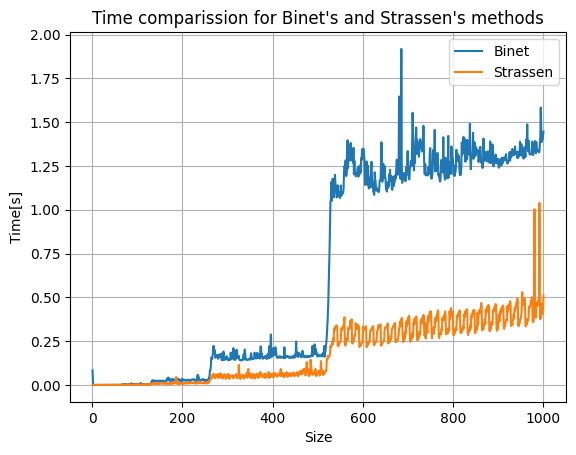

In [55]:
x = range(1, SIZE+1)
plt.plot(x, times_binet, label='Binet')
plt.plot(x, times_strassen, label='Strassen')

plt.xlabel('Size')
plt.ylabel('Time[s]')
plt.title('Time comparission for Binet\'s and Strassen\'s methods')
plt.legend()
plt.grid(True)
plt.savefig("charts/time.png")
plt.show()

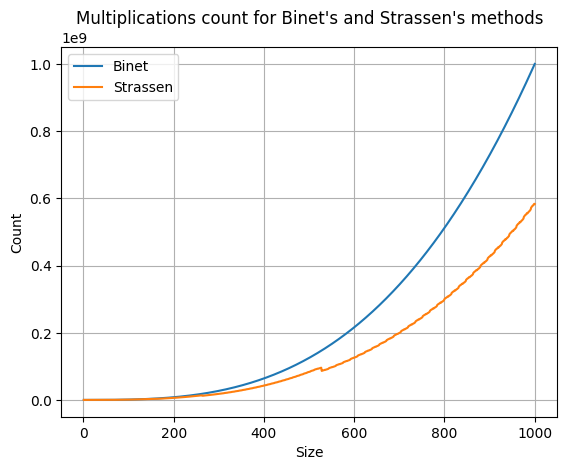

In [65]:
plt.plot(x, [y["mul"] for y in counts_binet], label='Binet')
plt.plot(x, [y["mul"] for y in counts_strassen], label='Strassen')

plt.xlabel('Size')
plt.ylabel('Count')
plt.title('Multiplications count for Binet\'s and Strassen\'s methods')
plt.legend()
plt.grid(True)
# plt.yscale("log")
plt.savefig("charts/mul_count.png")
plt.show()

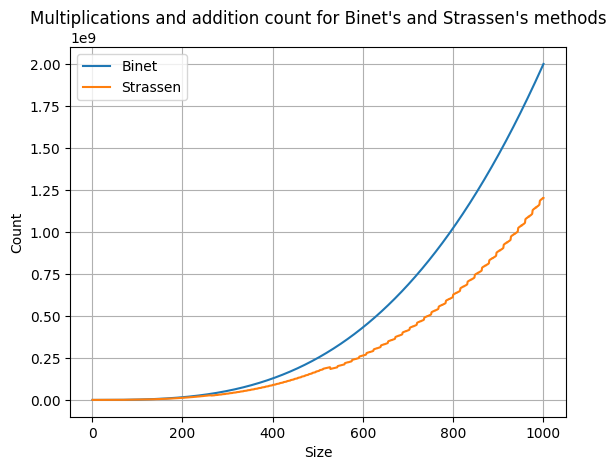

In [63]:
plt.plot(x, [y["mul"] + y["add"] for y in counts_binet], label='Binet')
plt.plot(x, [y["mul"] + y["add"] for y in counts_strassen], label='Strassen')

plt.xlabel('Size')
plt.ylabel('Count')
plt.title('Multiplications and addition count for Binet\'s and Strassen\'s methods')
plt.legend()
plt.grid(True)
# plt.yscale("log")
plt.savefig("charts/mul_add_count.png")
plt.show()

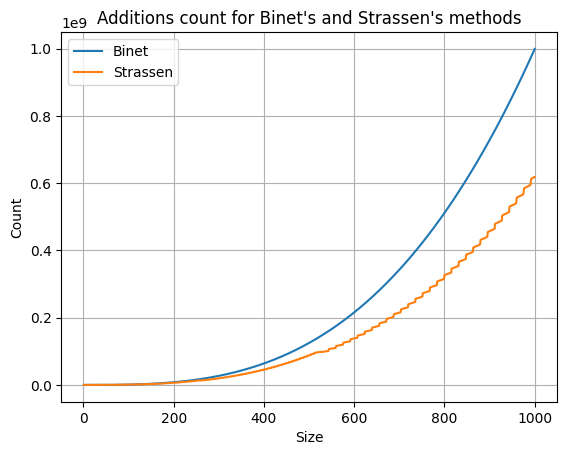

In [57]:
plt.plot(x, [y["add"] for y in counts_binet], label='Binet')
plt.plot(x, [y["add"] for y in counts_strassen], label='Strassen')

plt.xlabel('Size')
plt.ylabel('Count')
plt.title('Additions count for Binet\'s and Strassen\'s methods')
plt.legend()
plt.grid(True)
# plt.yscale("log")
plt.savefig("charts/add_count.png")
plt.show()

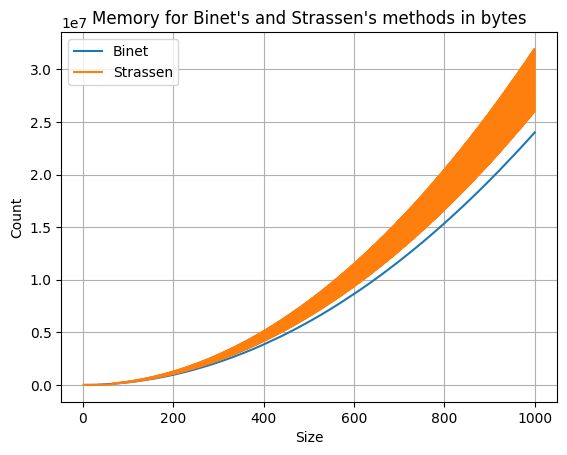

In [58]:
plt.plot(x[1:], memory_binet[1:], label='Binet')
plt.plot(x[1:], memory_strassen[1:], label='Strassen')

plt.xlabel('Size')
plt.ylabel('Count')
plt.title('Memory for Binet\'s and Strassen\'s methods in bytes')
plt.legend()
plt.grid(True)
# plt.yscale("log")
plt.savefig("charts/memory.png")
plt.show()